In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# A foreword

Typically e-commerce datasets are proprietary and consequently hard to find among publicly available data. However, The [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/index.php) has made this dataset containing actual transactions from 2010 and 2011. The dataset is maintained on their site, where it can be found by the title "Online Retail".

**Content**
"This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers."

**Acknowledgements**
Per the UCI Machine Learning Repository, this data was made available by Dr Daqing Chen, Director: Public Analytics group. chend '@' lsbu.ac.uk, School of Engineering, London South Bank University, London SE1 0AA, UK.

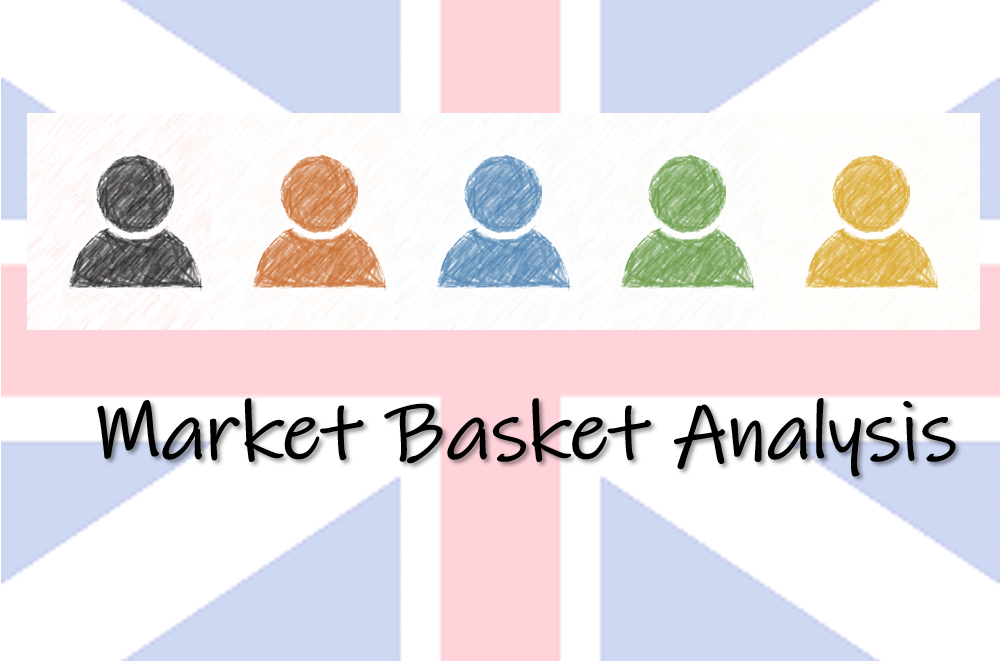

# EDA - Exploratory Data Analysis

In [ ]:
import pandas as pd
import numpy as np

import pandas_profiling as pp

import matplotlib.pyplot as plt
import seaborn as sns
import plotly as ply

**Read in the data**

In [ ]:
dat = pd.read_csv('../input/ecommerce-data/data.csv')

In [ ]:
print(dat.info(),'\n')
print(dat.describe(),'\n')
print(dat.sample(5),'\n')

**Measure non-null and unique entries per column**

In [ ]:
colstats = {}
for col in dat.columns:
#     print("{} has  {}  null entries ({:.1f}%) and  {}  unique entries ({:.1f}%)".format(col,
#                 dat[col].isnull().sum(),dat[col].isnull().sum()*100/dat.shape[0],
#                 len(dat[col].unique()),len(dat[col].unique())*100/dat.shape[0]))
    colstats[col] = [dat[col].isnull().sum(),dat[col].isnull().sum()*100/dat.shape[0],
                len(dat[col].unique()),len(dat[col].unique())*100/dat.shape[0]] 
    
stats_col = pd.DataFrame(colstats.values(), index = colstats.keys(),  columns = ['#Null','%Null','#Unique','%Unique'])
pd.set_option('precision',2)
pd.set_option('display.float_format', lambda x: '%.1f' % x)
print(stats_col)

Based on the table above, 25% of the data are missing CustomerID. All rows with missing Description have missing CustomerID as well.

In [ ]:
temp = dat[dat.Description.isnull()].copy()
print(temp.info())

**Orders by country**

In [ ]:
# orders by country
fig,ax = plt.subplots(1,1,figsize=(20,5))
stats_country = dat.groupby(['Country']).Quantity.agg([np.sum])
stats_country.sort_values(by='sum',ascending=False).plot(kind='bar',ax=ax).set_title('Count of orders by country')
plt.yscale("log")
plt.grid()

stats_country.sort_values(by='sum',ascending=False).head()

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(20,5))
temp = dat.copy()
temp['Value'] = temp['Quantity']*temp['UnitPrice']
stats_country = temp.groupby(['Country']).Value.agg([np.sum, np.mean])
stats_country.sort_values(by='sum',ascending=False).plot(kind='bar',ax=ax).set_title('Value of orders by country')
plt.yscale("log")
plt.grid()

stats_country.sort_values(by='mean',ascending=False).head()

In [ ]:
# Just a check to make sure that what the above cell is doing is right ...
# xx = temp[temp.Country.str.contains('United Kingdom')].copy()
# print(xx.Quantity.sum(), xx.Value.sum(), xx.Value.mean())

**Customer ID to country**

In [ ]:
stats_cust = dat.groupby(['CustomerID'])
for key,value in stats_cust:
    if len(value.Country.unique()) > 1:
        print(key, value.Country.unique())

The list of customers above seems to have placed orders from multiple countries. For others, there is a 1-to-1 mapping between customer and country.

**Stock code to description**

In [ ]:
stats_stock = dat.groupby(['StockCode'])
counter = 0
for key, value in stats_stock:
    if counter < 2:
        print(key)
        print(value.Description)
        counter += 1

The above analysis suggests that stockcode is uniquely mapped to the Description. If one were to use Description in the analysis and modeling, we can use StockCode to imput missing values. Alternately, in this case, I plan to drop Description in favor of using StockCode in any subsequent modeling I intend to do.

**Invoice number to date/time**

In [ ]:
temp = dat.groupby(['InvoiceNo'])
for key,value in temp:
    if len(value.InvoiceDate.unique()) > 1:
        print(key, value.InvoiceDate.unique())

Based on the analysis above, invoice number is uniquely related to the invoice date (within a sec or so).

**Preprocessing - imputing, removing nulls and duplicates**

In [ ]:
df = dat.copy()

In [ ]:
# Imput on Description based on StockCode - although I don't intend to use Description in any analysis
# xx = lambda x : x.mode().iloc[0]
# xxx = df.groupby(['StockCode']).apply(xx)
temp1 = df.groupby('StockCode').Description.agg(pd.Series.mode).to_frame()
df["Description"].fillna(lambda x: temp1.loc[x]["Description"],inplace=True)

In [ ]:
# temp = df.sample(5)
# print(temp.Description)
# print(dat.loc[temp.index]["Description"])

In [ ]:
df.info()

In [ ]:
lofInvoiceNo_NoCustID = list(set(df[df.CustomerID.isnull()].InvoiceNo))
print(df.CustomerID.isnull().sum(),len(lofInvoiceNo_NoCustID))

lofInvoiceNo_CustID = list(set(df[df.CustomerID.notnull()].InvoiceNo))
print(df.CustomerID.notnull().sum(),len(lofInvoiceNo_CustID))

print('Common InvoiceNo between rows that have CustomerId and those that do not', 
      list(set(lofInvoiceNo_NoCustID) & set(lofInvoiceNo_CustID)))       

Since there is no obvious way to imput missing CustomerID from the data, best option available seems to be to drop these rows.

In [ ]:
df.dropna(axis=0, inplace=True)
df.drop_duplicates(inplace=True)

In [ ]:
df.info()

In [ ]:
locancelledInvoice = df[df.Quantity < 0].InvoiceNo.unique()
locompletedInvoice = df[df.Quantity >= 0].InvoiceNo.unique()
# all cancelled orders have negative quantities ad InvoiceNo contains a C
if len(set(["C" in l for l in locancelledInvoice])) == 1:
    print("all cancelled orders have negative quantities and corresponding InvoiceNo contains a C")
    
    
if len(set(["C" in l for l in locompletedInvoice])) == 1:
    print("all successful orders have positive quantities and InvoiceNo is all digits")
    
n_cancelInvoice = len(locancelledInvoice)
n_completeInvoice = len(locompletedInvoice)
print("{} orders were canceled out of {} total orders ({:.1f}%)".format(n_cancelInvoice,
                                                                    n_completeInvoice+n_cancelInvoice, 
                                                                    n_cancelInvoice*100/(n_completeInvoice+n_cancelInvoice)))

df["OrderStatus_"]= "Completed"
df.loc[df[df.Quantity < 0].index,"OrderStatus_"] = "Cancellation"


In [ ]:
# checking to see if unit price per product is invariant over time
temp = df.groupby(["StockCode"]).UnitPrice.agg(['count','mean','sum'])
temp['Mean*Count'] = temp['mean']*temp['count']
temp.plot(kind='scatter',x='Mean*Count',y='sum')
plt.yscale('log')
plt.xscale('log')
plt.grid()

In [ ]:
df['Value_'] = df['Quantity']*df['UnitPrice']
df.groupby(["StockCode"])['Value_'].agg([np.sum]).tail(8).index
# Mark rows that have transactions "'BANK CHARGES', 'C2', 'CRUK', 'D', 'DOT', 'M', 'PADS', 'POST'" as "Exclude"
df["Exclude_"] = "False"
df.loc[df[df.StockCode.isin(df.groupby(["StockCode"])['Value_'].agg([np.sum]).tail(8).index)].index,"Exclude_"] = "True"

In [ ]:
# Convert returned negative quantity to postivie for analysis
df['PQuantity_'] = df['Quantity']
df.loc[df[df.Quantity < 0].index, 'PQuantity_'] = df.Quantity*-1

In [ ]:
df['Invoicedate_'] = pd.to_datetime(df['InvoiceDate'])

In [ ]:
df['OrderInvoiceNo_'] = ''
# df['CancelledAfterDays_'] = ''
temp = df[df['OrderStatus_'].str.contains("Cancellation")].copy()
ttemp = df[~df['OrderStatus_'].str.contains("Cancellation")].copy()

import time
st = time.time()
count = 0
for idx,row in temp.sort_values(by='PQuantity_',ascending=False).iterrows():  
    bl1 = (ttemp.CustomerID == row.CustomerID) & (ttemp.StockCode == row.StockCode) 
    bl2 = (ttemp.PQuantity_ >= row.PQuantity_) & (ttemp.Invoicedate_ < row.Invoicedate_)
    stemp = ttemp[bl1 & bl2].copy()
    if stemp.shape[0] == 1:
        if stemp.iloc[0]['PQuantity_'] == row.PQuantity_:
            temp.loc[idx,'OrderInvoiceNo_'] = stemp.iloc[0].InvoiceNo
        else:
            temp.loc[idx,'OrderInvoiceNo_'] = stemp.iloc[0].InvoiceNo
            temp.loc[idx, 'OrderStatus_'] = 'PartialReturn'
    else:            
        temp.loc[idx, 'OrderStatus_'] = 'NoCorrOrder'  
    count += 1
    if count%500 == 0:
        print('Completed ... {:.0f}%'.format(count/temp.shape[0]*100))
en = time.time()
print("Elapsed time (s) = ",en-st)
# takes about 10 min

In [ ]:
df.loc[temp.index] = temp

In [ ]:
df.info()

In [ ]:
df['Month_'] = pd.DatetimeIndex(df.Invoicedate_).month
df['Year_']= pd.DatetimeIndex(df.Invoicedate_).year
df['Day_']= pd.DatetimeIndex(df.Invoicedate_).day
df['Time_']=pd.DatetimeIndex(df.Invoicedate_).hour
df.sample(10)

# Analysis of the prepared data

**Order Analysis**

In [ ]:
import warnings
warnings.filterwarnings('ignore')

*Size of transactions by basket size and value*

In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,5)) 
df.groupby('OrderStatus_').PQuantity_.agg(['count']).plot(kind='bar',ax=ax1).set_title("# of transactions")
ax1.set_yscale('log')
df.groupby('OrderStatus_').PQuantity_.agg(['sum']).plot(kind='bar',ax=ax2).set_title("value of all transactions")
ax2.set_yscale('log')
df.groupby('OrderStatus_').PQuantity_.agg(['mean']).plot(kind='bar',ax=ax3).set_title("expected value of all transactions")
ax3.set_yscale('log')

In [ ]:
print('Value of canceled transactions is {:.1f}% of fulfilled transactions'.format(-100*df[df.Quantity < 0].Value_.sum()/df[df.Quantity >= 0].Value_.sum()))

> While the total number of transactions cancelled is at 16%, the total value of the cancelled transactions is only 7%.

*Trends in sales through the year*

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(20,5)) 
df.groupby(['Month_','OrderStatus_']).PQuantity_.agg(['count']).unstack(level=0).plot(kind='bar',ax=ax)
plt.yscale("log")

*Orders and cancelations trends during a 24-hour period*

In [ ]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(20,10)) 
df.groupby(['OrderStatus_','Time_']).PQuantity_.agg(['count']).unstack(level=0).plot(kind='bar',ax=ax1).set_title("# of transactions")
ax1.set_yscale("log")
df.groupby(['OrderStatus_','Time_']).PQuantity_.agg(['sum']).unstack(level=0).plot(kind='bar',ax=ax2).set_title("Value of transactions")
ax2.set_yscale("log")

> There seem to be more transactions during the holiday season, as there are cancellations.

*Transaction size*

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,5)) 
temp = df[df.Quantity >= 0].copy()
temp1 = df[df.Quantity < 0].copy()
temp.groupby(['InvoiceNo']).StockCode.agg(['count']).plot(kind='hist',ax=ax1, bins=40).set_title("Average number of products per transaction")
ax1.set_yscale("log")
temp.groupby(['InvoiceNo']).Quantity.agg(['sum']).rename(columns={'sum':'Fulfilled'}).plot(kind='hist',ax=ax2, bins=40, edgecolor='k').set_title("Average number of items per transaction")
temp1.groupby(['InvoiceNo']).PQuantity_.agg(['sum']).rename(columns={'sum':'Cancelled'}).plot(kind='hist',ax=ax2, bins=40,alpha=0.5)
ax2.set_yscale("log")
ax2.legend()

> ... as is obvious from the nature of the wholesale business.

**Market segmentation - Geographical/Customer**

*Geographical distribution of sales*

In [ ]:
# orders by country
fig,ax = plt.subplots(1,1,figsize=(20,5))
stats_country = df.groupby(['Country']).Quantity.agg([np.sum])
stats_country.sort_values(by='sum',ascending=False).plot(kind='bar',ax=ax).set_title('Count of orders by country')
plt.yscale("log")
plt.grid()

stats_country.sort_values(by='sum',ascending=False).head()

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(20,5))
stats_country = df.groupby(['Country']).Value_.agg([np.sum, np.mean])
stats_country.sort_values(by='mean',ascending=False).plot(kind='bar',ax=ax).set_title('Value of orders by country')
plt.yscale("log")
plt.grid()

stats_country.sort_values(by='mean',ascending=False).head()

*Most valuable customers*

In [ ]:
fig, ax1 = plt.subplots(1,1,figsize=(20,7))
temp = df[df.OrderStatus_ == 'Completed']

nrows_Head = 15
vtemp = temp.groupby(['CustomerID']).Value_.agg([np.sum]).rename(columns={'sum':'Value'}).sort_values(by='Value',ascending=False)
# vtemp.head(nrows_Head).plot(kind='bar',ax=ax).set_title('Value of orders by customer ( with cumulative % of total value on each customer)')

vtemp['cumValue'] = vtemp.cumsum(axis=0)
vtemp['PercentValue'] = vtemp.cumValue*100/vtemp['Value'].sum()

for i,p in enumerate(ax1.patches):
    ax.annotate(str(np.round(vtemp.iloc[i]['PercentValue'], decimals=1))+'%', (p.get_x() * 1.005, p.get_height() * 1.015))
    
vtemp1 = temp.groupby(['CustomerID','Country']).Value_.agg([np.sum]).rename(columns={'sum':'Value'}).sort_values(by='Value',ascending=False)
vtemp1.head(nrows_Head).unstack(level=1).plot(kind='bar',ax=ax1, width=1.2).set_title('Value of orders by customer')

xtemp = vtemp.head(nrows_Head)
xtemp.reset_index(inplace=True)
ax2 = ax1.twinx()
sns.lineplot(x = xtemp.index, y= xtemp['PercentValue'], ax=ax2, color='k')
ax2.set_xticklabels(xtemp.CustomerID)

> Most of the value is generated across 15 customers who account for 20% of the total value generated.

**Market Segmentation - Product**

*Most popular products*

In [ ]:
# most popular products
fig,ax = plt.subplots(1,1,figsize=(20,5))
temp = df[df.OrderStatus_ == 'Completed'].copy()
temp.groupby(['Description']).Quantity.agg([np.sum]).sort_values(by='sum',ascending=False).rename(columns={'sum':'Quantity'}).head(20).plot(kind="bar",ax=ax).set_title('Top products by quantity sold')
plt.yscale('log')
plt.grid()

*Most canceled products*

In [ ]:
# returned products
fig,ax = plt.subplots(1,1,figsize=(20,5))
temp = df[(df.Quantity < 0) & (df.Exclude_ == "False")].copy()
temp.groupby(['Description','OrderStatus_']).PQuantity_.agg([np.sum]).sort_values(by='sum',ascending=False).rename(columns={'sum':'Quantity'}).head(20).unstack(level=1).plot(kind="bar",ax=ax, width=1.2).set_title('Top products canceled')
plt.yscale('log')
plt.grid()

> Looking at the charts above, the top two most sold products are also the most commonly canceled/returned product.

*Most value generating products*

In [ ]:
# most valued products in terms of reveneue generating
fig,ax = plt.subplots(1,1,figsize=(20,5))
temp = df[(df.OrderStatus_ == 'Completed') & (df.Exclude_ == 'False')].copy()
vtemp = temp.groupby(['Description']).Value_.agg([np.sum]).sort_values(by='sum',ascending=False).head(20).plot(kind="bar",ax=ax).set_title('Top revenue earning products by value')

plt.yscale("log")
plt.grid()

*Seasonality in product sales*

In [ ]:
fig,ax = plt.subplots(4,3,figsize=(20,20),sharex=True)

temp = df[(df.OrderStatus_ == 'Completed') & (df.Exclude_ == 'False') & (df.Quantity <= 60000)].copy()
vtemp = temp.groupby(['Month_','Description']).Quantity.agg(['sum'])
for i in range(12):
    r,c=divmod(i,3)    
    vtemp.query('Month_ == '+str(i+1)).sort_values(by='sum',ascending=False).head(10).unstack(level=0).plot(kind='barh',ax=ax[r,c]).set_title('Month_ == '+str(i+1))
#     ax[r,c].set_xscale('log')
#     vtemp.query('Month_ == '+str(i+1)).sort_values(by='sum',ascending=False).head(10).index
#     ax[r,c].set_xticklabels(vtemp.query('Month_ == '+str(i+1)).sort_values(by='sum',ascending=False).head(10).index.get_level_values('Description'))
fig.tight_layout()